In [1]:
import matplotlib.pyplot as plt
import numpy as np
import modules as ms
from time import time
from astropy.table import Table
import healpy as hp
import fitsio as ft

In [2]:
import sys
sys.path.insert(0, '/users/PHS0336/medirz90/github/LSSutils')
import lssutils.utils as ut

In [3]:
%matplotlib inline

In [3]:
loader =  ms.DataLoader(maskbits=[1, 12, 13])

data_dir            : /fs/ess/PHS0336/data/elgmask
gaia_path           : /fs/ess/PHS0336/data/elgmask/gaia_lrg_mask_v1.fits
gaia_suppl_path     : /fs/ess/PHS0336/data/elgmask/gaia_reference_suppl_dr9.fits
gaia_columns        : ['RA', 'DEC', 'mask_mag']
target_class        : ELG
maskbits            : [1, 12, 13]
min_nobs            : 1



north bmzls
# of targets: 11857336
# of targets (after maskbits=[1, 12, 13]): 11857336
# of targets (after LMC cut): 11857336
# of targets (after min_nobs >= 1): 11857336
# of targets: 51558408
# of targets (after maskbits=[1, 12, 13]): 50954831
# of targets (after LMC cut): 50954831
# of targets (after min_nobs >= 1): 50124760
0.9570027181264251 after


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


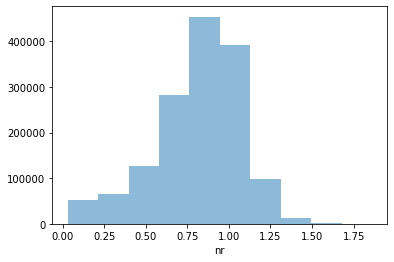

south ndecals
# of targets: 35360631
# of targets (after maskbits=[1, 12, 13]): 35360631
# of targets (after LMC cut): 34836102
# of targets (after min_nobs >= 1): 34836102
# of targets: 155396056
# of targets (after maskbits=[1, 12, 13]): 153649077
# of targets (after LMC cut): 151878758
# of targets (after min_nobs >= 1): 143383338
0.9894782725994732 after


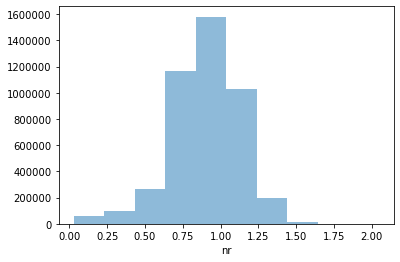

south sdecals
# of targets: 35360631
# of targets (after maskbits=[1, 12, 13]): 35360631
# of targets (after LMC cut): 34836102
# of targets (after min_nobs >= 1): 34836102
# of targets: 155396056
# of targets (after maskbits=[1, 12, 13]): 153649077
# of targets (after LMC cut): 151878758
# of targets (after min_nobs >= 1): 143383338
0.9895394583252873 after


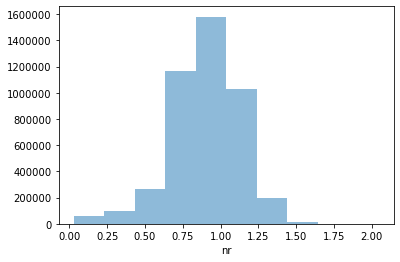

In [6]:
for region in ['bmzls', 'ndecals', 'sdecals']:
    
    field = 'north' if region=='bmzls' else 'south'
    print(field, region)
    
    cat = loader.read_cat(field)         # read target catalog
    ran = loader.read_randoms(field)     # read random catalog

    # Gaia and Siena mask
    is_badr0 = np.load(f'is_badr_{field}_siena.npy')
    is_bad0 = np.load(f'is_bad_{field}_siena.npy')
    is_badr1 = np.load(f'is_badr_{field}.npy')
    is_bad1 = np.load(f'is_bad_{field}.npy')

    is_bad = is_bad0 | is_bad1
    is_badr = is_badr0 | is_badr1

    cat = cat[~is_bad]
    ran = ran[~is_badr]
    
    ng = ut.hpixsum(1024, cat['RA'], cat['DEC'])*1.0
    nr = ut.hpixsum(1024, ran['RA'], ran['DEC'])*1.0
    
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')
    dt['label'][:] = np.nan
    dt['fracgood'][:] = np.nan

    is_good = nr > 0
    ng[~is_good] = np.nan
    nr[~is_good] = np.nan
    
    nr[is_good] = nr[is_good]/(2500*hp.nside2pixarea(1024, degrees=True)*4.0)
    dt['label'] = ng[dt['hpix']]
    dt['fracgood'] = nr[dt['hpix']]    
    
    is_ok = np.ones(dt.size, '?')
    for field in ['label', 'fracgood']:
        is_ok &= np.isfinite(dt[field])
    print(is_ok.mean(), 'after')
    dt_ok = dt[is_ok]
    ft.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_1024.fits', dt_ok)

    plt.figure()
    plt.hist(nr, alpha=0.5)
    plt.xlabel('nr')
    plt.show()

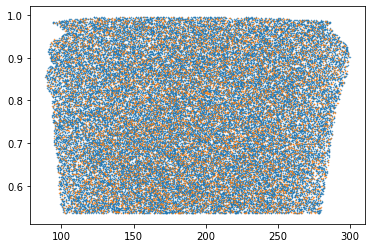

In [27]:
sin = lambda deg: np.sin(np.radians(deg))

plt.scatter(ran['RA'][::1000], sin(ran['DEC'][::1000]), 1, alpha=0.8, marker='.')
plt.scatter(cat['RA'][::1000], sin(cat['DEC'][::1000]), 1, alpha=0.8, marker='.')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


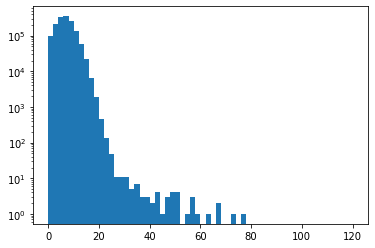

In [78]:
plt.hist(ng[nr > 0], range=(0, 120.), bins=60,)
plt.hist(dt['label'], range=(0, 120.), bins=60, alpha=0.5)
plt.yscale('log')

In [4]:
import fitsio as ft

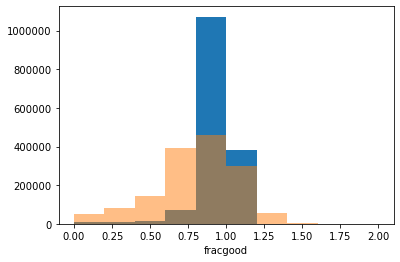

-4.30 117.0 77.0


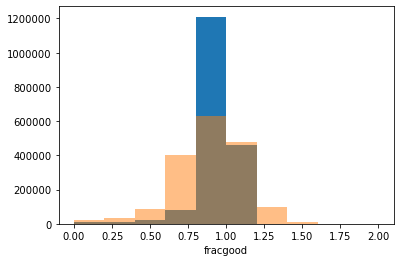

-1.05 465.0 53.0


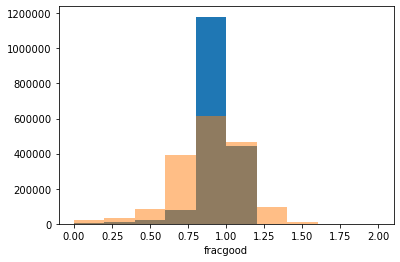

-1.05 48.0 46.0


In [10]:
for region in ['bmzls', 'ndecals', 'sdecals']:
    d0 = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')
    d1 = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v4/nelg_features_{region}_1024.fits')
    
    plt.hist(d0['fracgood'], range=(0, 2.))
    plt.hist(d1['fracgood'], range=(0, 2.), alpha=0.5)
    plt.xlabel('fracgood')
    plt.show()
    
    print('%.2f'%((d1.size/d0.size-1)*100), d0['label'].max(), d1['label'].max())